<a href="https://colab.research.google.com/github/hwangzie/Detect-Corner-Mark-on-Device-and-Image-Quality/blob/main/testing_addmetadata_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#testing and adding metadata

##load the model and library

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [ ]:
tflite_model_file = pathlib.Path('/content/finalmodelup.tflite')
# tflite_model_file.write_bytes(tflite_model_file)

## Initialize the TFLite interpreter to try it out

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model_file.read_bytes())
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

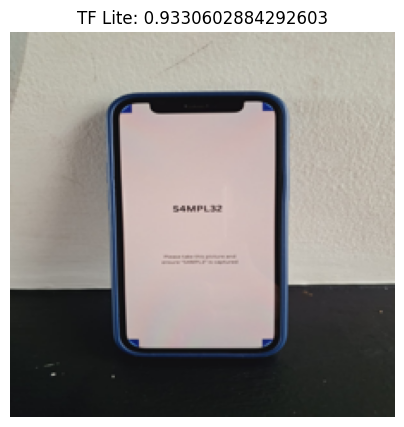

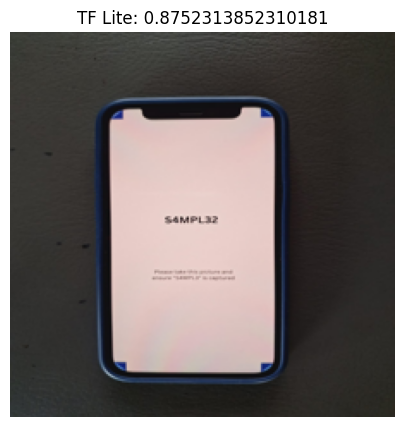

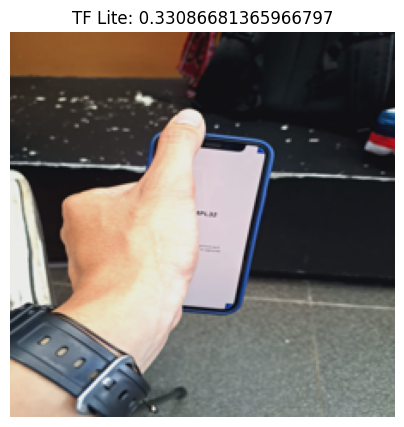

In [ ]:
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt

# Create an upload button
upload_button = widgets.FileUpload(accept='image/*', multiple=True)  # Allow multiple files
display(upload_button)

def predict_uploaded_image(interpreter, input_details, output_details, uploaded_file):
  """Predicts the class of an uploaded image using both TensorFlow and TensorFlow Lite."""

  # Preprocess the image
  img = Image.open(io.BytesIO(uploaded_file['content']))
  img = img.resize((224, 224))
  img = img.convert('RGB')
  img_array = np.array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

  # TensorFlow Lite prediction
  interpreter.set_tensor(input_details[0]['index'], img_array)
  interpreter.invoke()
  tflite_results = interpreter.get_tensor(output_details[0]['index'])

  # Display results and image in a subplot
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(img)
  ax.set_title(f"TF Lite: {tflite_results[0][0]}")
  ax.axis('off')
  plt.show()


def on_upload_change(change):
  """Handles the upload button change event."""
  for uploaded_file in upload_button.value.values():
    predict_uploaded_image(interpreter, input_details, output_details, uploaded_file)

# Observe the upload button for changes
upload_button.observe(on_upload_change, names='value')

#Add the meta data

##installing the library for metadata

In [ ]:
!pip install --upgrade tflite-support-nightly

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

##adding the metadata

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "/content/finalmodelup.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "label.txt"
_SAVE_TO_PATH = "final_model_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba